In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
import zipfile
import os
import random as rn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import pickle
import tensorflow_datasets as tfds
import tensorflow_hub as hub
######### mixed precision training ######################
from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy(policy="mixed_float16")

# Image Classification
This is a skills check for image classification for the Tensorflow Exam

## Project 1: Horses vs Humans (Conv2d)

In [40]:
! wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip

local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

--2022-11-19 20:38:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  23.4MB/s    in 7.3s    

2022-11-19 20:38:49 (19.5 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



### Understand how ImageDataGenerator labels images based on the directory structure
### Use ImageDataGenerator

In [41]:
train_main_dir = "/content/horse-or-human"

#train_datagen = ImageDataGenerator(rescale=1/255.0,horizontal_flip=True,vertical_flip=True,zoom_range=.3,shear_range=.3,rotation_range=.3)
train_datagen = ImageDataGenerator(rescale=1/255.0)
train_generator = train_datagen.flow_from_directory(
    train_main_dir,
    target_size=(224,224),
    batch_size=128,
    class_mode='binary',
)

Found 1027 images belonging to 2 classes.


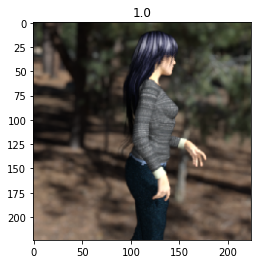

In [42]:
i = rn.randint(0,127)
img, label = next(train_generator)
plt.title(label[i])
plt.imshow(img[i])

In [43]:
! wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip

local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('./validation-horse-or-human.')
zip_ref.close()

--2022-11-19 20:39:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘validation-horse-or-human.zip’

validation-horse-or 100%[===================>]  10.95M  7.22MB/s    in 1.5s    

2022-11-19 20:39:10 (7.22 MB/s) - ‘validation-horse-or-human.zip’ saved [11480187/11480187]



In [44]:
val_main_dir = "/content/validation-horse-or-human."

val_datagen = ImageDataGenerator(rescale=1/255.0)
val_generator = train_datagen.flow_from_directory(
    val_main_dir,
    target_size=(224,224),
    batch_size=128,
    class_mode='binary'
)

Found 256 images belonging to 2 classes.


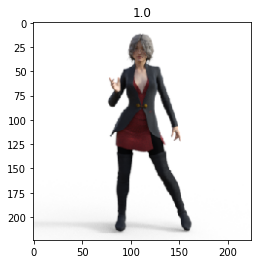

In [45]:
i = rn.randint(0,127)
img, label = next(val_generator)
plt.title(label[i])
plt.imshow(img[i])

### Define Convolutional neural networks with Conv2D and pooling layers

In [46]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= 0.99:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()
# Create the learning rate callback
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16,(3,3),activation="relu",input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
              metrics=["accuracy"])

history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks=[callback])

Epoch 1/20
9/9 [==============================] - 9s 743ms/step - loss: 0.6807 - accuracy: 0.6758 - val_loss: 0.5141 - val_accuracy: 0.8203
Epoch 2/20
9/9 [==============================] - 7s 744ms/step - loss: 0.3657 - accuracy: 0.8471 - val_loss: 1.8294 - val_accuracy: 0.6875
Epoch 3/20
9/9 [==============================] - 7s 844ms/step - loss: 0.2359 - accuracy: 0.9056 - val_loss: 0.8686 - val_accuracy: 0.8555
Epoch 4/20
9/9 [==============================] - 7s 845ms/step - loss: 0.1997 - accuracy: 0.9202 - val_loss: 1.2661 - val_accuracy: 0.7578
Epoch 5/20
9/9 [==============================] - 7s 762ms/step - loss: 0.1000 - accuracy: 0.9611 - val_loss: 1.9024 - val_accuracy: 0.7070
Epoch 6/20
9/9 [==============================] - 7s 763ms/step - loss: 0.0443 - accuracy: 0.9854 - val_loss: 1.8102 - val_accuracy: 0.8047
Epoch 7/20
9/9 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9903
Reached 99.9% accuracy so cancelling training!
9/9 [================

In [9]:
# plot learning rate results
def plot_learning_rate(history,epochs=9):
  lrs = 1e-3 * (10**(np.arange(epochs)/20))
  print(len(lrs))
  plt.semilogx(lrs, history.history["loss"]) # want the x-axis to be log-scale
  plt.xlabel("Learning rate")
  plt.ylabel("Loss")
  plt.title("Finding the ideal learning rate");

#plot_learning_rate(history,epochs=12)

### Project 2 Continued - Transfer Learning with Keras Model Instance

In [47]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers:
  layer.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x = base_model(inputs,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512,activation="relu")(x)
x = tf.keras.layers.Dropout(.3)(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

tf_model = tf.keras.Model(inputs,outputs)

tf_model.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy']
                 )

history2 = tf_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    #callbacks=[callback]

)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/5
9/9 [==============================] - 12s 872ms/step - loss: 0.1668 - accuracy: 0.9231 - val_loss: 7.9520e-07 - val_accuracy: 1.0000
Epoch 2/5
9/9 [==============================] - 7s 781ms/step - loss: 0.0633 - accuracy: 0.9990 - val_loss: 4.8095e-37 - val_accuracy: 1.0000
Epoch 3/5
9/9 [==============================] - 7s 770ms/step - loss: 0.1018 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
9/9 [==============================] - 8s 856ms/step - loss: 2.6404e-23 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
9/9 [==============================] - 7s 782ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.8313e-28 - val_accuracy: 1.0000


In [48]:
test_acc = tf_model.evaluate(val_generator)
test_acc

2/2 [==============================] - 1s 409ms/step - loss: 4.8313e-28 - accuracy: 1.0000


[4.831284821237795e-28, 1.0]

### Project 2 Continued - Transfer Learning with TF-Hub

In [56]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/classification/1",trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy']
              )

model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
9/9 [==============================] - 17s 1s/step - loss: 0.6700 - accuracy: 0.9289 - val_loss: 0.6516 - val_accuracy: 1.0000
Epoch 2/5
9/9 [==============================] - 7s 811ms/step - loss: 0.6143 - accuracy: 0.9990 - val_loss: 0.5892 - val_accuracy: 1.0000
Epoch 3/5
9/9 [==============================] - 7s 813ms/step - loss: 0.5382 - accuracy: 0.9990 - val_loss: 0.5098 - val_accuracy: 1.0000
Epoch 4/5
9/9 [==============================] - 7s 804ms/step - loss: 0.4472 - accuracy: 0.9990 - val_loss: 0.4207 - val_accuracy: 1.0000
Epoch 5/5
9/9 [==============================] - 8s 978ms/step - loss: 0.3555 - accuracy: 0.9990 - val_loss: 0.3316 - val_accuracy: 1.0000


In [57]:
model.evaluate(val_generator)

2/2 [==============================] - 1s 381ms/step - loss: 0.3316 - accuracy: 1.0000


[0.3316303491592407, 1.0]

## Project 2: Traffic Signals
### Build and train models to process real-world image datasets
### Use real-world images in different shapes and sizes

In [12]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
!unzip -q traffic-signs-data.zip

--2022-11-14 23:29:32--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 13.249.90.90, 13.249.90.78, 13.249.90.229, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|13.249.90.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  79.2MB/s    in 1.5s    

2022-11-14 23:29:33 (79.2 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]



In [13]:
# read in files
train_data = pickle.load(open("train.p","rb"))
val_data = pickle.load(open("valid.p","rb"))
test_data = pickle.load(open("test.p","rb"))

print(f"Train features: {train_data.keys()}, Total samples: {len(train_data['labels'])}")
print(f"Validation features: {val_data.keys()}, Total samples: {len(val_data['labels'])}")
print(f"Test features: {test_data.keys()}, Total samples: {len(test_data['labels'])}")

Train features: dict_keys(['coords', 'labels', 'features', 'sizes']), Total samples: 34799
Validation features: dict_keys(['coords', 'labels', 'features', 'sizes']), Total samples: 4410
Test features: dict_keys(['sizes', 'coords', 'features', 'labels']), Total samples: 12630


In [14]:
def size_check(features):
  features = set([feature.shape for feature in features])
  return np.array(list(features))

all_data = [train_data,val_data,test_data]

for data in all_data:
  shapes = size_check(data['features'])
  print(f"Total shapes: {len(shapes)}\n {shapes}")

Total shapes: 1
 [[32 32  3]]
Total shapes: 1
 [[32 32  3]]
Total shapes: 1
 [[32 32  3]]


In [15]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

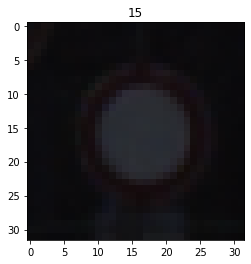

In [16]:
n = len(X_train)
i = rn.randint(0,n)
img, label = X_train[i], y_train[i]
plt.title(label)
plt.imshow(img)

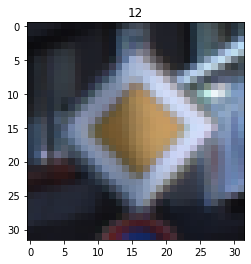

In [17]:
n = len(X_val)
i = rn.randint(0,n)
img, label = X_val[i], y_val[i]
plt.title(label)
plt.imshow(img)

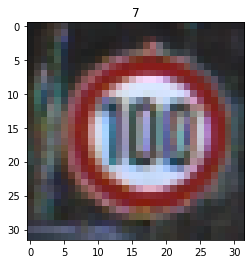

In [18]:
n = len(X_test)
i = rn.randint(0,n)
img, label = X_test[i], y_test[i]
plt.title(label)
plt.imshow(img)

In [19]:
# prepare for batch loading
# shuffle data
# data augmentation

BATCH_SIZE = 128

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None
  )

train_generator = train_datagen.flow(
    
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    shuffle=True

)

valid_datagen = ImageDataGenerator(
    rescale=1/255.0
  )

valid_generator = valid_datagen.flow(
    x=X_val,
    y=y_val,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale=1/255.0
  )

test_generator = test_datagen.flow(
    x=X_test,
    y=y_test,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [20]:
# model
INPUT_SHAPE = (32,32,3)
NUM_CLASSES = 43

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=2,activation="relu",input_shape=INPUT_SHAPE,padding='same'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filters=32,kernel_size=2,activation="relu",padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filters=64,kernel_size=2,activation="relu",padding='same'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filters=64,kernel_size=2,activation="relu",padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dense(units=NUM_CLASSES,activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        416       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [21]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history3 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20
)

Epoch 1/20
272/272 [==============================] - 5s 17ms/step - loss: 0.6046 - accuracy: 0.8521 - val_loss: 3.1603 - val_accuracy: 0.3385
Epoch 2/20
272/272 [==============================] - 4s 15ms/step - loss: 0.0431 - accuracy: 0.9879 - val_loss: 0.7439 - val_accuracy: 0.8036
Epoch 3/20
272/272 [==============================] - 4s 15ms/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.4546 - val_accuracy: 0.8991
Epoch 4/20
272/272 [==============================] - 4s 15ms/step - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.6499 - val_accuracy: 0.8717
Epoch 5/20
272/272 [==============================] - 4s 15ms/step - loss: 0.0319 - accuracy: 0.9902 - val_loss: 0.7184 - val_accuracy: 0.8671
Epoch 6/20
272/272 [==============================] - 4s 15ms/step - loss: 0.0304 - accuracy: 0.9912 - val_loss: 0.6531 - val_accuracy: 0.8789
Epoch 7/20
272/272 [==============================] - 4s 15ms/step - loss: 0.0201 - accuracy: 0.9940 - val_loss: 0.4922 - val_accuracy: 0.9122

In [22]:
# saved model
model.save("traffic_sign.h5")

In [23]:
# read in saved model and evaluate against val set
saved_model = tf.keras.models.load_model("traffic_sign.h5")
saved_model.evaluate(valid_generator)

35/35 [==============================] - 0s 9ms/step - loss: 0.4383 - accuracy: 0.9522


[0.43825462460517883, 0.9521542191505432]

In [24]:
saved_model.evaluate(test_generator)

99/99 [==============================] - 1s 10ms/step - loss: 0.6339 - accuracy: 0.9375


[0.6339343190193176, 0.9375296831130981]

## Project 3: Tensorflow Dataset Example- Cassava

Classification of leaf images for the cassava plant depicting four conditions. A brief practice of utilizing Tensorflow datasets

In [58]:
(train,val,test), ds_info = tfds.load("cassava",
                        split=["train","validation","test"],
                        as_supervised=True,
                        shuffle_files=True,
                        with_info=True)

ds_info.features

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5656 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cassava/0.1.0.incompleteDXH53G/cassava-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/1885 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cassava/0.1.0.incompleteDXH53G/cassava-test.tfrecord*...:   0%|          | 0/1…

Generating validation examples...:   0%|          | 0/1889 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cassava/0.1.0.incompleteDXH53G/cassava-validation.tfrecord*...:   0%|         …

Dataset cassava downloaded and prepared to ~/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

(500, 500, 3)


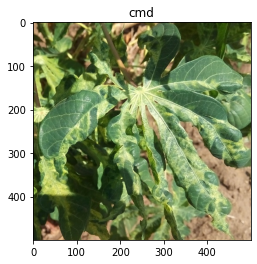

In [26]:
sample = train.take(1)

for image,label in sample:
  print(image.shape)
  plt.title(ds_info.features['label'].names[label.numpy()])
  plt.imshow(image)

(500, 625, 3)


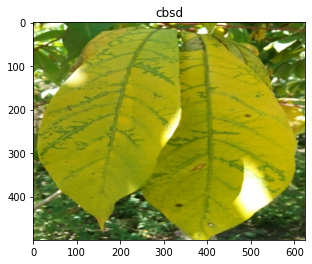

In [27]:
sample = val.take(1)

for image,label in sample:
  print(image.shape)
  plt.title(ds_info.features['label'].names[label.numpy()])
  plt.imshow(image)

(666, 500, 3)


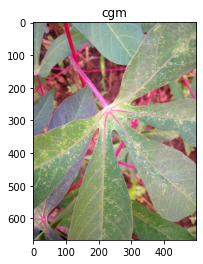

In [28]:
sample = test.take(1)

for image,label in sample:
  print(image.shape)
  plt.title(ds_info.features['label'].names[label.numpy()])
  plt.imshow(image)

In [ ]:
train_shapes = np.array(list(set([image.shape for image,label in train])))
val_shapes = np.array(list(set([image.shape for image,label in val])))
test_shapes = np.array(list(set([image.shape for image,label in test])))

In [59]:
INPUT_SHAPE = (224,224,3)

def preprocess_img(image,label,dim=224):
  image = tf.image.resize(image,[dim,dim])
  return tf.cast(image,tf.float32)/255.0, label

train = train.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
train = train.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

val = val.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
val = val.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test = test.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
test = test.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [62]:
train.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [40]:
checkpoint_path = "best_model_cassava.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights = True)

In [39]:
NUM_CLASSES = 5

input_image = tf.keras.Input(shape=INPUT_SHAPE, name='input_image',dtype=tf.float32)

base_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    input_tensor=input_image,
    #pooling="avg"
)

for layer in base_model.layers:
  layer.trainable = False

model = tf.keras.Sequential([
    # data augmentation
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(.2),

   # base model
    base_model,

   tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(512,activation="relu"),
   #tf.keras.layers.Dropout(.4),
   tf.keras.layers.Dense(NUM_CLASSES,activation="softmax")
])

In [41]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [42]:
history4 = model.fit(
    train,
    epochs=25,
    steps_per_epoch=len(train),
    validation_data=val,
    validation_steps=int(.15*len(val)),
    callbacks=[model_checkpoint]
)

Epoch 1/25
177/177 [==============================] - ETA: 0s - loss: 0.9449 - accuracy: 0.6519
Epoch 1: val_accuracy improved from -inf to 0.70486, saving model to best_model_cassava.h5
177/177 [==============================] - 59s 248ms/step - loss: 0.9449 - accuracy: 0.6519 - val_loss: 0.8080 - val_accuracy: 0.7049
Epoch 2/25
177/177 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.7283
Epoch 2: val_accuracy improved from 0.70486 to 0.72917, saving model to best_model_cassava.h5
177/177 [==============================] - 43s 231ms/step - loss: 0.7452 - accuracy: 0.7283 - val_loss: 0.7388 - val_accuracy: 0.7292
Epoch 3/25
177/177 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.7519
Epoch 3: val_accuracy did not improve from 0.72917
177/177 [==============================] - 42s 225ms/step - loss: 0.6760 - accuracy: 0.7519 - val_loss: 0.8473 - val_accuracy: 0.6771
Epoch 4/25
177/177 [==============================] - ETA: 0s - loss: 0.65

In [44]:
model.evaluate(test)

59/59 [==============================] - 12s 144ms/step - loss: 0.5947 - accuracy: 0.7947


[0.5947290062904358, 0.7946949601173401]

### Project 3 Continued - Fine Tuning

In [4]:
checkpoint_path = "best_model_cassava.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

NUM_CLASSES = 5

input_image = tf.keras.Input(shape=INPUT_SHAPE, name='input_image',dtype=tf.float32)

base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    input_tensor=input_image,
)

###### FINE TUNING STEP ##########################
base_model.trainable = True
fine_tune_at = 10

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
##################################################

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.Dense(NUM_CLASSES,activation="softmax")
])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 11,178,292
Trainable params: 11,089,389
Non

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
              metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights = True)

history5 = model.fit(
    train,
    epochs=50,
    steps_per_epoch=len(train),
    validation_data=val,
    validation_steps=int(.15*len(val)),
    callbacks=[model_checkpoint]
)

In [6]:
model.evaluate(test)

59/59 [==============================] - 11s 134ms/step - loss: 0.7757 - accuracy: 0.8048


[0.775668740272522, 0.8047745227813721]

## Project 4: MNIST (Keras Dataset)

In [14]:
(train_images,train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.expand_dims(train_images,-1)
test_images = np.expand_dims(test_images,-1)

In [16]:
train_data = tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_images,test_labels))
train_data, test_data

(<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>)

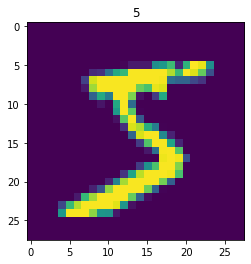

In [29]:
sample_image, label = next(iter(train_data))
plt.title(label.numpy().item())
plt.imshow(np.squeeze(sample_image));

In [31]:
BUFFER_SIZE=1000
BATCH_SIZE=64
train_data_ = train_data.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_ = test_data.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
INPUT_SHAPE = next(iter(train_data_))[0].shape

model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1/255.0),
    tf.keras.layers.Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=INPUT_SHAPE),
    tf.keras.layers.AveragePooling2D(2,2),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
    tf.keras.layers.AveragePooling2D(2,2),

    tf.keras.layers.Conv2D(filters=16,kernel_size=3,activation='relu'),
    tf.keras.layers.AveragePooling2D(2,2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10,activation="softmax")

])

model.build(INPUT_SHAPE)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (64, 28, 28, 1)           0         
                                                                 
 conv2d_12 (Conv2D)          (64, 26, 26, 16)          160       
                                                                 
 average_pooling2d_12 (Avera  (64, 13, 13, 16)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (64, 11, 11, 32)          4640      
                                                                 
 average_pooling2d_13 (Avera  (64, 5, 5, 32)           0         
 gePooling2D)                                                    
                                                                 
 conv2d_14 (Conv2D)          (64, 3, 3, 16)           

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics='accuracy')

history = model.fit(train_data_,validation_data=test_data_,epochs=20)

Epoch 1/20
938/938 [==============================] - 13s 5ms/step - loss: 0.5893 - accuracy: 0.8187 - val_loss: 0.2751 - val_accuracy: 0.9159
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.2246 - accuracy: 0.9324 - val_loss: 0.1676 - val_accuracy: 0.9473
Epoch 3/20
938/938 [==============================] - 5s 5ms/step - loss: 0.1716 - accuracy: 0.9481 - val_loss: 0.1464 - val_accuracy: 0.9537
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1480 - accuracy: 0.9551 - val_loss: 0.1330 - val_accuracy: 0.9591
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1296 - accuracy: 0.9603 - val_loss: 0.1229 - val_accuracy: 0.9612
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1143 - accuracy: 0.9649 - val_loss: 0.1024 - val_accuracy: 0.9692
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1025 - accuracy: 0.9682 - val_loss: 0.0918 - val_accuracy: 0.9728
Epoch